# OPTRAM

In [38]:
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
import rasterio as rs
from scipy import stats
import sys
import glob
import haversine as hs
from haversine import Unit
from shapely.geometry import Point

### Functions

In [129]:
def utm_to_latlon(coords, zone_number, zone_letter):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)


def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt


def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + 'SCL/' + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)

        
def S2_get_sensing_dt(boa_fp):
    days_offset = 1
    start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
    end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)
    
    start_dt = start_dt.strftime('%Y-%m-%d')
    end_dt   = end_dt.strftime('%Y-%m-%d')

    print('Requesting image metadata between %s <-> %s' % (start_dt, end_dt))

    # bash callback: 
    dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
    sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')
    return sensing_datetime


def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc


def build_inSitu_obs(df, dest_lat_lng, utm_n = 12, utm_z = 'N') :
    
    x = df.loc[:,'utm_x'].tolist()
    y = df.loc[:,'utm_y'].tolist()
    
    dists = [  hs.haversine(utm_to_latlon(item, utm_n, utm_Z),
                            dest_lat_lng, unit = Unit.METERS)
        
               for item in zip(x,y) 
    ]
    
    df['dist'] = dists
    df.sort_values('dist', inplace  = True)
    
    return df.head(1)

def get_px_coords_from_raster(boa) :
    dataset = boa
    val = boa.read(3, masked = True)
    no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    return (zip(*coords_utm))

In [116]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)
    

In [112]:
df = tif_df.loc[:, ['utm_x', 'utm_y']]

build_inSitu_obs(df    = tif_df,
                 dest_lat_lng  = TDRL1_latlong,
                 utm_n = 12,
                 utm_z = 'N')

NameError: name 'coords_df_utm' is not defined

## REGION OF STUDY


In [25]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


Plotting with Folium requires lat, long data, so we have to convert from UTM

In [26]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [27]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html
TDRL1_utm = [589567, 3512290] 
TDRL2_utm = [589793, 3512420]
RG28_utm  = [590624, 3509990]

TDRL1_latlong = utm_to_latlon(coords = TDRL1_utm, 
                              zone_number = utm_N,
                              zone_letter = utm_Z)

TDRL2_latlong = utm_to_latlon(coords = TDRL2_utm, 
                              zone_number = utm_N,
                              zone_letter = utm_Z)

RG28_latlong = utm_to_latlon(coords = RG28_utm, 
                             zone_number = utm_N,
                             zone_letter = utm_Z)

In [39]:
m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    

folium.Marker(TDRL1_latlong, popup="TDRL1").add_to(m)
m.add_child(folium.ClickForMarker(popup="Waypoint"))

folium.Marker(TDRL2_latlong, popup="TDRL2").add_to(m)
m.add_child(folium.ClickForMarker(popup="Waypoint"))

folium.Marker(RG28_latlong, popup="RG28").add_to(m)
m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

 Shapefile to geojson conversion

In [29]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [30]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
l1tdr18 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l1tdr18.out',
                  sep='\s+', 
                  names = names)

l2tdr18 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l2tdr18.out',
                  sep='\s+', 
                  names = names)

names = ["site", "year", "day", "hr", "mn", "SM5", "ST5"]
rg28    = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/RaingageSiteData/rg28vt18.out',
                  sep=',', 
                  names = names)

In [31]:
l1tdr18["datetime"] = (
                        pd.to_datetime(l1tdr18['year'] * 1000 + l1tdr18['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l1tdr18["hr"], unit="h") 
                        +
                        pd.to_timedelta(l1tdr18["mn"], unit="min") 
                      )

l2tdr18["datetime"] = (
                        pd.to_datetime(l2tdr18['year'] * 1000 + l2tdr18['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l2tdr18["hr"], unit="h") 
                        +
                        pd.to_timedelta(l2tdr18["mn"], unit="min") 
                      )

rg28["datetime"]    = (
                        pd.to_datetime(rg28['year'] * 1000 + rg28['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(rg28["hr"], unit="h") 
                        +
                        pd.to_timedelta(rg28["mn"], unit="min") 
                      )

In [32]:
l1tdr18.set_index('datetime', inplace = True)
l2tdr18.set_index('datetime', inplace = True)
rg28.set_index('datetime', inplace = True)

In [33]:
l1tdr18
l2tdr18
rg28

,site,year,day,hr,mn,SM5,ST5
datetime,,,,,,,
2018-01-01 00:30:00,28,2018,1,0,30,4,7.22
2018-01-01 01:00:00,28,2018,1,1,0,4,6.83
2018-01-01 01:30:00,28,2018,1,1,30,4,6.45
2018-01-01 02:00:00,28,2018,1,2,0,4,6.10
2018-01-01 02:30:00,28,2018,1,2,30,4,5.79
...,...,...,...,...,...,...,...
2018-12-31 22:00:00,28,2018,365,22,0,6999,6999.00
2018-12-31 22:30:00,28,2018,365,22,30,6999,6999.00
2018-12-31 23:00:00,28,2018,365,23,0,6999,6999.00


Its obvious **6999** represent a _no_data_ value.

In [34]:
l1tdr18_fix = l1tdr18.replace(6999, None)
l2tdr18_fix = l2tdr18.replace(6999, None)
rg28_fix    = rg28.replace(6999, None)

In [15]:
#fig, (ax1, ax2) = plt.subplots(2, figsize = (10,3), sharex= True)
#fig.suptitle('l1tdr18 - SM 5 cm')
#ax1.plot(l1tdr18.loc[:,'SM5'].index, l1tdr18.loc[:,'SM5'])
#ax2.plot(l2tdr18.loc[:,'SM5'].index, l2tdr18.loc[:,'SM5'])

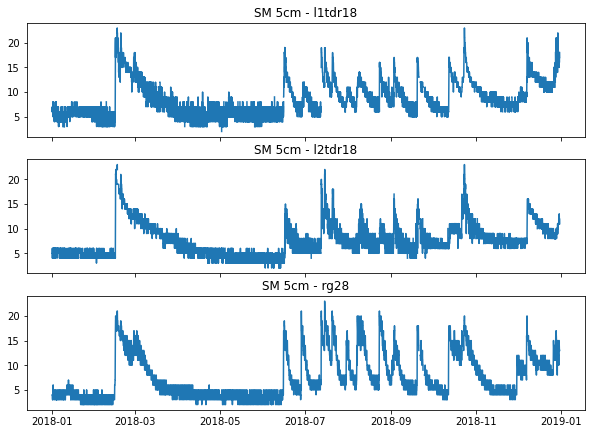

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,5), sharex= True)
ax1.plot(l1tdr18_fix.loc[:,'SM5'].index, l1tdr18_fix.loc[:,'SM5'])
ax2.plot(l2tdr18_fix.loc[:,'SM5'].index, l2tdr18_fix.loc[:,'SM5'])
ax3.plot(rg28_fix.loc[:,'SM5'].index, rg28_fix.loc[:,'SM5'])

ax1.title.set_text('SM 5cm - l1tdr18')
ax2.title.set_text('SM 5cm - l2tdr18')
ax3.title.set_text('SM 5cm - rg28')

#https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2 , wspace=None, hspace=None)


### Satellite

Example for df creation of 1 image: 

In [36]:
BASE_DIR = './sen2r/out/'
boa_fp = BASE_DIR + "BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
raster_date = S2_getDate(boa_fp)
scl_fp = S2_getSCL(BASE_DIR, raster_date)


boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
r    = boa.read(3, masked = True)
nir  = boa.read(8, masked = True)
swir = boa.read(11, masked = True)
swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
ndvi = (nir - r)/(nir + r)
STR  = ((1-swir)**2)/(2*swir)
scl  = scl.read(1, masked = True)

utm_x, utm_y =  get_px_coords_from_raster(boa)

data = {
    'datetime' : S2_get_sensing_dt(boa_fp),
    'ndvi' : np.ndarray.flatten(ndvi[~ndvi.mask]),
    'str'  : np.ndarray.flatten(STR[~STR.mask]),
    'defective_px_perc' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
    'utm_x' : utm_x, 
    'utm_y' : utm_y,
    'fpath' : boa_fp
}

tif_df = pd.DataFrame(data)
tif_df.drop(tif_df[tif_df.loc[:,"ndvi"] > 1].index, inplace=True)

In [124]:
tif_df

,datetime,ndvi,str,defective_px_perc,utm_x,utm_y,fpath
0,2018-12-13 17:57:31,0.461230,1.539247,0.349034,605485.0,3515705.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
1,2018-12-13 17:57:31,0.396426,1.539247,0.349034,605495.0,3515705.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
2,2018-12-13 17:57:31,0.371065,1.385681,0.349034,605505.0,3515705.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
3,2018-12-13 17:57:31,0.391123,1.385681,0.349034,605515.0,3515705.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
4,2018-12-13 17:57:31,0.315341,1.258945,0.349034,605525.0,3515705.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
...,...,...,...,...,...,...,...
1239726,2018-12-13 17:57:31,0.330512,1.625479,0.349034,591425.0,3503605.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
1239727,2018-12-13 17:57:31,0.356216,1.625479,0.349034,591435.0,3503605.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
1239728,2018-12-13 17:57:31,0.361736,1.470884,0.349034,591395.0,3503595.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...
1239729,2018-12-13 17:57:31,0.364985,1.563391,0.349034,591405.0,3503595.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...


Building the in_situ dfs

In [125]:
inSitu_obs = build_inSitu_obs(df    = tif_df,
                              dest_lat_lng  = TDRL1_latlong,
                              utm_n = 12,
                              utm_z = 'N')
inSitu_obs

,datetime,ndvi,str,defective_px_perc,utm_x,utm_y,fpath,dist
305432,2018-12-13 17:57:31,0.31312,1.012699,0.349034,589565.0,3512285.0,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,5.398217


# BASURA

In [ ]:
type(boa)

In [ ]:
py, px = boa.index(RG28_latlong[0], RG28_latlong[1]) # px coordinaes

print(px, py)

In [ ]:
print(boa.indexes)
print(boa.dtypes)

In [ ]:
boa.profile

In [ ]:
boa.lnglat() #???

In [ ]:
boa.xy

In [ ]:
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
nir

In [ ]:
ndvi

In [ ]:
# https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
from shapely.geometry import Point

dataset = boa
val = ndvi
no_data = dataset.nodata
geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
df.crs = dataset.crs
geometry

In [ ]:
print(geometry[0].xy[0])

In [ ]:
boa.read(8, masked = True)

----------